In [1]:
import numpy as np
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython
from td_utils import *
from datetime import time
%matplotlib inline

c:\users\asus\appdata\local\programs\python\python35\lib\site-packages\pydub\utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
Tx = 5998 # The number of time steps input to the model from the spectrogram
n_freq = 101 # Number of frequencies input to the model at each time step of the spectrogram

In [3]:
Ty = 1496 # The number of time steps in the output of our model

In [4]:
# Load audio segments using pydub 
roshansho, negatives, backgrounds = load_raw_audio()
print("background len: " + str(len(roshansho[0])))    # Should be 10,000, since it is a 10 sec clip
print("activate[0] len: " + str(len(roshansho[8])))     # Maybe around 1000, since an "activate" audio clip is usually around 1 sec (but varies a lot)
print("activate[1] len: " + str(len(roshansho[1])))     # Different "activate" clips can have different lengths

background len: 1286
activate[0] len: 1678
activate[1] len: 1286


In [5]:
print("background len: " + str(len(backgrounds)))    # Should be 10,000, since it is a 10 sec clip
print("roshansho[0] len: " + str(len(roshansho)))     # Maybe around 1000, since an "activate" audio clip is usually around 1 sec (but varies a lot)
print("negatives[1] len: " + str(len(negatives)))  

background len: 55
roshansho[0] len: 35
negatives[1] len: 191


In [6]:
def get_random_time_segment(segment_ms):
    """
    Gets a random time segment of duration segment_ms in a 10,000 ms audio clip.
    
    Arguments:
    segment_ms -- the duration of the audio clip in ms ("ms" stands for "milliseconds")
    
    Returns:
    segment_time -- a tuple of (segment_start, segment_end) in ms
    """
    
    segment_start = np.random.randint(low=0, high=10000-segment_ms)   # Make sure segment doesn't run past the 10sec background 
    segment_end = segment_start + segment_ms - 1
    
    return (segment_start, segment_end)

In [7]:
def is_overlapping(segment_time, previous_segments):
    """
    Checks if the time of a segment overlaps with the times of existing segments.
    
    Arguments:
    segment_time -- a tuple of (segment_start, segment_end) for the new segment
    previous_segments -- a list of tuples of (segment_start, segment_end) for the existing segments
    
    Returns:
    True if the time segment overlaps with any of the existing segments, False otherwise
    """
    
    segment_start, segment_end = segment_time
    
    # Step 1: Initialize overlap as a "False" flag.
    overlap = False
    
    # Step 2: loop over the previous_segments start and end times.
    # Compare start/end times and set the flag to True if there is an overlap
    for previous_start, previous_end in previous_segments:
        if segment_start <= previous_end and segment_end >= previous_start:
            overlap = True

    return overlap

In [14]:
def insert_audio_clip(background, audio_clip, previous_segments):
    """
    Insert a new audio segment over the background noise at a random time step, ensuring that the 
    audio segment does not overlap with existing segments.
    
    Arguments:
    background -- a 10 second background audio recording.  
    audio_clip -- the audio clip to be inserted/overlaid. 
    previous_segments -- times where audio segments have already been placed
    
    Returns:
    new_background -- the updated background audio
    """
    
    # Get the duration of the audio clip in ms
    segment_ms = len(audio_clip)
    
    # Step 1: Use one of the helper functions to pick a random time segment onto which to insert 
    # the new audio clip. 
    segment_time = get_random_time_segment(segment_ms)
    
    # Step 2: Check if the new segment_time overlaps with one of the previous_segments. If so, keep 
    # picking new segment_time at random until it doesn't overlap.
    count=0
    while is_overlapping(segment_time, previous_segments)and (count<100):
        segment_time = get_random_time_segment(segment_ms)
        count+=1

    # Step 3: Add the new segment_time to the list of previous_segments 
    if(count<100):
        previous_segments.append(segment_time)
    
    # Step 4: Superpose audio segment and background
        new_background = background.overlay(audio_clip, position = segment_time[0])
    
        return new_background, segment_time
    else:
        return background

In [9]:
def insert_ones(y, segment_end_ms):
    """
    Update the label vector y. The labels of the 50 output steps strictly after the end of the segment 
    should be set to 1. By strictly we mean that the label of segment_end_y should be 0 while, the
    50 followinf labels should be ones.
    
    
    Arguments:
    y -- numpy array of shape (1, Ty), the labels of the training example
    segment_end_ms -- the end time of the segment in ms
    
    Returns:
    y -- updated labels
    """
    
    # duration of the background (in terms of spectrogram time-steps)
    segment_end_y = int(segment_end_ms * Ty / 10000.0)
    
    # Add 1 to the correct index in the background label (y)
    for i in range(segment_end_y+1, segment_end_y+51):
        if i < Ty:
            y[0, i] = 1.0
    
    return y

In [12]:
def create_training_example(background, activates, negatives,i):
    """
    Creates a training example with a given background, activates, and negatives.
    
    Arguments:
    background -- a 10 second background audio recording
    activates -- a list of audio segments of the word "activate"
    negatives -- a list of audio segments of random words that are not "activate"
    
    Returns:
    x -- the spectrogram of the training example
    y -- the label at each time step of the spectrogram
    """
    
    # Set the random seed
    #np.random.seed(time.now())
    
    # Make background quieter
    background = background - 20

    # Step 1: Initialize y (label vector) of zeros 
    y = np.zeros((1, Ty))

    # Step 2: Initialize segment times as empty list 
    previous_segments = []
    
    # Select 0-4 random "activate" audio clips from the entire list of "activates" recordings
    number_of_activates = np.random.randint(0, 5)
    random_indices = np.random.randint(len(activates), size=number_of_activates)
    random_activates = [activates[i] for i in random_indices]
    
    # Step 3: Loop over randomly selected "activate" clips and insert in background
    for random_activate in random_activates:
        # Insert the audio clip on the background
        try:
            background, segment_time = insert_audio_clip(background, random_activate, previous_segments)
            # Retrieve segment_start and segment_end from segment_time
            segment_start, segment_end = segment_time
            # Insert labels in "y"
            y = insert_ones(y, segment_end)
        except:
            print('')

    # Select 0-2 random negatives audio recordings from the entire list of "negatives" recordings
    number_of_negatives = np.random.randint(0, 3)
    random_indices = np.random.randint(len(negatives), size=number_of_negatives)
    random_negatives = [negatives[i] for i in random_indices]

    # Step 4: Loop over randomly selected negative clips and insert in background
    for random_negative in random_negatives:
        # Insert the audio clip on the background 
        background = insert_audio_clip(background, random_negative, previous_segments)[0]
    
    # Standardize the volume of the audio clip 
    background = match_target_amplitude(background, -20.0)

    # Export new training example 
    file_handle = background.export("validation/validation"+str(i) + ".wav", format="wav")
    print("File (train.wav) "+str(i)+"was saved in your directory.")
    
    # Get and plot spectrogram of the new recording (background with superposition of positive and negatives)
    x = graph_spectrogram("validation/validation"+str(i)+".wav")
    
    return x, y

File (train.wav) 500was saved in your directory.
File (train.wav) 501was saved in your directory.
An exception occurred (101, 1)


c:\users\asus\appdata\local\programs\python\python35\lib\site-packages\matplotlib\mlab.py:1246: UserWarning: Only one segment is calculated since parameter NFFT (=200) >= signal length (=48).
  "(=%d) >= signal length (=%d)." % (NFFT, len(x)))
c:\users\asus\appdata\local\programs\python\python35\lib\site-packages\matplotlib\axes\_axes.py:7609: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


File (train.wav) 501was saved in your directory.

File (train.wav) 502was saved in your directory.
File (train.wav) 503was saved in your directory.
File (train.wav) 504was saved in your directory.
File (train.wav) 505was saved in your directory.
File (train.wav) 506was saved in your directory.
File (train.wav) 507was saved in your directory.

File (train.wav) 508was saved in your directory.
An exception occurred (101, 1)
File (train.wav) 508was saved in your directory.
File (train.wav) 509was saved in your directory.
File (train.wav) 510was saved in your directory.
File (train.wav) 511was saved in your directory.
File (train.wav) 512was saved in your directory.
An exception occurred (101, 1)
File (train.wav) 512was saved in your directory.
File (train.wav) 513was saved in your directory.
An exception occurred (101, 1)
File (train.wav) 513was saved in your directory.
File (train.wav) 514was saved in your directory.
File (train.wav) 515was saved in your directory.
An exception occurred (


File (train.wav) 618was saved in your directory.
File (train.wav) 619was saved in your directory.
File (train.wav) 620was saved in your directory.
File (train.wav) 621was saved in your directory.
An exception occurred (101, 1)
File (train.wav) 621was saved in your directory.
An exception occurred (101, 2754)
File (train.wav) 621was saved in your directory.
File (train.wav) 622was saved in your directory.
File (train.wav) 623was saved in your directory.
File (train.wav) 624was saved in your directory.
An exception occurred (101, 1)
File (train.wav) 624was saved in your directory.
File (train.wav) 625was saved in your directory.

File (train.wav) 626was saved in your directory.
An exception occurred (101, 1)
File (train.wav) 626was saved in your directory.
File (train.wav) 627was saved in your directory.
File (train.wav) 628was saved in your directory.
File (train.wav) 629was saved in your directory.
An exception occurred (101, 1)
File (train.wav) 629was saved in your directory.
File (t

File (train.wav) 732was saved in your directory.
File (train.wav) 733was saved in your directory.
File (train.wav) 734was saved in your directory.
File (train.wav) 735was saved in your directory.
File (train.wav) 736was saved in your directory.
File (train.wav) 737was saved in your directory.
An exception occurred (101, 1)
File (train.wav) 737was saved in your directory.
File (train.wav) 738was saved in your directory.
File (train.wav) 739was saved in your directory.
An exception occurred (101, 1)
File (train.wav) 739was saved in your directory.
File (train.wav) 740was saved in your directory.
File (train.wav) 741was saved in your directory.
File (train.wav) 742was saved in your directory.
An exception occurred (101, 1)
File (train.wav) 742was saved in your directory.
File (train.wav) 743was saved in your directory.
An exception occurred (101, 1)
File (train.wav) 743was saved in your directory.
File (train.wav) 744was saved in your directory.
File (train.wav) 745was saved in your direc

File (train.wav) 852was saved in your directory.
File (train.wav) 853was saved in your directory.
File (train.wav) 854was saved in your directory.
File (train.wav) 855was saved in your directory.
An exception occurred (101, 2754)
File (train.wav) 855was saved in your directory.
An exception occurred (101, 1)
File (train.wav) 855was saved in your directory.
File (train.wav) 856was saved in your directory.
An exception occurred (101, 5511)
File (train.wav) 856was saved in your directory.
File (train.wav) 857was saved in your directory.
File (train.wav) 858was saved in your directory.
File (train.wav) 859was saved in your directory.
An exception occurred (101, 1)

File (train.wav) 859was saved in your directory.
An exception occurred (101, 1)
File (train.wav) 859was saved in your directory.
File (train.wav) 860was saved in your directory.
File (train.wav) 861was saved in your directory.
File (train.wav) 862was saved in your directory.
File (train.wav) 863was saved in your directory.
File 

File (train.wav) 957was saved in your directory.
File (train.wav) 958was saved in your directory.
File (train.wav) 959was saved in your directory.
File (train.wav) 960was saved in your directory.
File (train.wav) 961was saved in your directory.

File (train.wav) 962was saved in your directory.
An exception occurred (101, 1)
File (train.wav) 962was saved in your directory.
File (train.wav) 963was saved in your directory.
File (train.wav) 964was saved in your directory.
An exception occurred (101, 1)
File (train.wav) 964was saved in your directory.
File (train.wav) 965was saved in your directory.
An exception occurred (101, 1)
File (train.wav) 965was saved in your directory.
An exception occurred (101, 2754)
File (train.wav) 965was saved in your directory.
An exception occurred (101, 1)
File (train.wav) 965was saved in your directory.
File (train.wav) 966was saved in your directory.
File (train.wav) 967was saved in your directory.
File (train.wav) 968was saved in your directory.
File (tr

c:\users\asus\appdata\local\programs\python\python35\lib\site-packages\matplotlib\image.py:395: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
c:\users\asus\appdata\local\programs\python\python35\lib\site-packages\matplotlib\image.py:396: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
c:\users\asus\appdata\local\programs\python\python35\lib\site-packages\matplotlib\image.py:403: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
c:\users\asus\appdata\local\programs\python\python35\lib\site-packages\matplotlib\image.py:408: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
c:\users\asus\appdata\local\programs\python\python35\lib\site-packages\matplotlib\colors.py:918: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
c:\users\asus\appdata\local\programs\python\python35\lib\site-packag

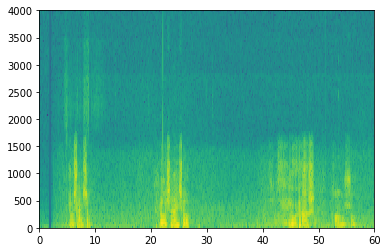

In [13]:
result_array_X = np.empty((1,5998, 101))
result_array_Y = np.empty((1,1496, 1))
count=500
while count<1000:
    r=count%55
    x,y=create_training_example(backgrounds[r], roshansho, negatives,count)
    try:
        y=y.reshape(1,1496,1)
        x=x.reshape(1,5998, 101)
        result_array_X=np.concatenate([x,result_array_X],axis=0)
        result_array_Y=np.concatenate([y,result_array_Y],axis=0)
        count+=1
    except:
      print("An exception occurred",x.shape)

    

File (train.wav) 987was saved in your directory.


c:\users\asus\appdata\local\programs\python\python35\lib\site-packages\matplotlib\axes\_axes.py:7609: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


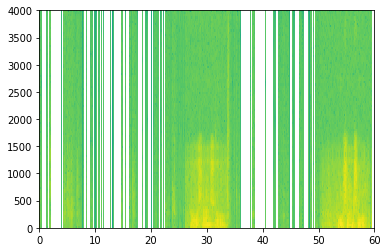

In [57]:
print(result_array_X.shape)
result_array_Y.shape

(501, 5998, 101)


(501, 1496, 1)

In [58]:
result_array_X=np.delete(result_array_X,0,axis=0)

In [23]:
result_array_Y.shape

(500, 1496, 1)

In [59]:
result_array_Y=np.delete(result_array_Y,0,axis=0)

In [60]:
np.save('result_array_X_validation_1.npy', result_array_X)

In [61]:
np.save('result_array_Y_validation_1.npy', result_array_Y)

In [46]:
X = np.load("result_array_X.npy")
Y = np.load("result_array_Y.npy")

In [31]:
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam

Using TensorFlow backend.


In [32]:
def model(input_shape):
    """
    Function creating the model's graph in Keras.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)

    Returns:
    model -- Keras model instance
    """
    
    X_input = Input(shape = input_shape)
      
    # Step 1: CONV layer
    X = Conv1D(196, 15, strides=4)(X_input)                    # CONV1D
    X = BatchNormalization()(X)                                # Batch normalization
    X = Activation('relu')(X)                                  # ReLu activation
    X = Dropout(0.8)(X)                                        # dropout (use 0.8)

    # Step 2: First GRU Layer
    X = GRU(units = 128, return_sequences=True)(X)             # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                        # dropout (use 0.8)
    X = BatchNormalization()(X)                                # Batch normalization
    
    # Step 3: Second GRU Layer
    X = GRU(units = 128, return_sequences=True)(X)             # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                        # dropout (use 0.8)
    X = BatchNormalization()(X)                                # Batch normalization
    X = Dropout(0.8)(X)                                        # dropout (use 0.8)
    
    # Step 4: Time-distributed dense layer
    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X) # time distributed  (sigmoid)

    model = Model(inputs = X_input, outputs = X)
    
    return model  

In [34]:
model = model(input_shape = (Tx, n_freq))

In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5998, 101)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1496, 196)         297136    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1496, 196)         784       
_________________________________________________________________
activation_1 (Activation)    (None, 1496, 196)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1496, 196)         0         
_________________________________________________________________
gru_1 (GRU)                  (None, 1496, 128)         124800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1496, 128)         0         
__________

In [36]:
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

In [47]:
model.fit(X, Y, batch_size = 5, epochs=1)

Epoch 1/1
51/51 [==============================] - 97s 2s/step - loss: 1.1226 - acc: 0.4852
